In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_32073/2809884579.py:45: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


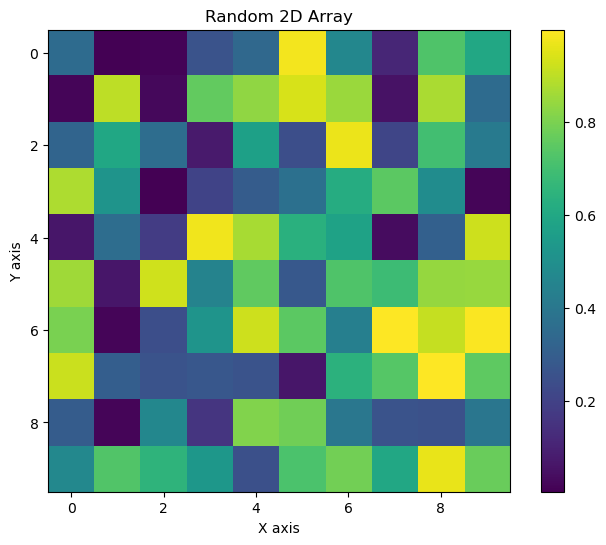

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = True, 
                    dvs_duration = 1000000,

                    OTTT_sWS_on = True, # True # False
                  ):
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and convTrue_fcFalse == True


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    
    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    wandb.config.update(hyperparameters)
    wandb.run.name = f'sstep_lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
    wandb.define_metric("summary_val_acc", summary="max")
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    torch.manual_seed(my_seed)
    ###################################################################################################################################


    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                print('past_in_channel', past_in_channel)
                print('bias_param', bias_param)
                print('in_channel', in_channel)
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if pre_trained == False:
        # if (convTrue_fcFalse == False):
        #     net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
        #              synapse_fc_trace_const1, synapse_fc_trace_const2, 
        #              lif_layer_v_init, lif_layer_v_decay, 
        #              lif_layer_v_threshold, lif_layer_v_reset,
        #              lif_layer_sg_width,
        #              tdBN_on,
        #              BN_on, TIME,
        #              surrogate,
        #              BPTT_on).to(device)
        # else:
        #     net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
        #              synapse_conv_kernel_size, synapse_conv_stride, 
        #              synapse_conv_padding, synapse_conv_trace_const1, 
        #              synapse_conv_trace_const2, 
        #              lif_layer_v_init, lif_layer_v_decay, 
        #              lif_layer_v_threshold, lif_layer_v_reset,
        #              lif_layer_sg_width,
        #              synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
        #              tdBN_on,
        #              BN_on, TIME,
        #              surrogate,
        #              BPTT_on,
        #              OTTT_sWS_on).to(device)
        
        # if (nda_net == True):
        #     net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
        #               lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        #     net.T = TIME
        net = MY_SNN_CONV_ottt_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                     synapse_conv_kernel_size, synapse_conv_stride, 
                     synapse_conv_padding, synapse_conv_trace_const1, 
                     synapse_conv_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on,
                     OTTT_sWS_on).to(device)
        net = torch.nn.DataParallel(net) #나중에풀어줘
    else:
        net = torch.load(pre_trained_path)

    net = net.to(device)
    if (net_print == True):
        print(net)        
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    if (weight_count_print == True):
        for name, param in net.named_parameters():
            if param.requires_grad:
                print(f'Layer: {name} | Number of parameters: {param.numel()}')
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])
    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()
        running_loss = 0.0

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(iterator)):
            validation_interval2 = len(iterator)
        ##################################################################################################



        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            # print('inputs',inputs.size(),'\nlabels',labels.size())
                    
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                

                
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH)
            # ######################################################################################################


            labels = labels.repeat(TIME, 1)
            
            ## device로 보내주기 ######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################



            
            x_seq = inputs
            target_seq = labels
            # [T, B, ...]

            T = x_seq.shape[0]

            batch_loss = 0.
            y_all = []
            optimizer.zero_grad()
            for t in range(T):
                y_t = net(x_seq[t])
                # print('y_t',y_t.size())#[128, 10])
                # print('target_seq[t]',target_seq[t].size())#([1, 1, 1, 128])
                y_all.append(y_t)
            
            # y_all: [B, T, ...]
            outputs_all = torch.stack(y_all, dim=1)
            mean_out = outputs_all.mean(1) 

            loss = criterion(mean_out, target_seq[0].contiguous())
            batch_loss += loss.data
            loss.backward()
            optimizer.step()

            outputs = mean_out
            iter_loss = batch_loss



            batch = BATCH 
            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            assert predicted.size(0) == labels[0].size(0), 'batch값 안맞노'
            total = labels.size(1)
            correct = (predicted == labels[0]).sum().item()
            tr_total += total
            tr_correct += correct
            iter_acc = correct / total
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter_acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            
            

            ### gradinet verbose ##########################################
            if (gradient_verbose == True):
                if (i % verbose_interval == verbose_interval-1):
                    print('\n\nepoch', epoch, 'iter', i)
                    for name, param in net.named_parameters():
                        if param.requires_grad:
                            print('\n\n\n\n' , name, param.grad)
            ################################################################
            


            running_loss += iter_loss.item()
            # print("Epoch: {}, Iter: {}, Loss: {}".format(epoch + 1, i + 1, running_loss / 100))

            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                val_loss = 0.
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        inputs, labels = data
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        # inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)
                        outputs_all=[]
                        _, predicted = torch.max(outputs.data, 1)
                        for tt in range(TIME):
                            # compute output
                            outputs = net(inputs)
                            loss = criterion(outputs, labels)
                            outputs_all.append(outputs.detach())
                            val_loss += loss.data
                        outputs_all = torch.stack(outputs_all, dim=1)
                        mean_out = outputs_all.mean(1)
                        assert mean_out.size(0) == labels.size(0), 'batch값 안맞노'
                        _, predicted = torch.max(mean_out.data, 1)
                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)
                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    # torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                    # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                    # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                    # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            iterator.set_description(f"iter_acc: {iter_acc_string}, iter_loss: {loss}, val_acc: {100 * val_acc_now:.2f}%")  
            wandb.log({"iter_acc": iter_acc}, step=i+epoch*len(train_loader))
            wandb.log({"tr_acc": tr_acc}, step=i+epoch*len(train_loader))
            wandb.log({"val_acc_now": val_acc_now}, step=i+epoch*len(train_loader))
            wandb.log({"summary_val_acc": val_acc_now})
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### 모듈 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # np.save(iter_acc_file_name_time, iter_acc_array)
            # np.save(tr_acc_file_name_time, iter_acc_array)
            # np.save(val_acc_file_name_time, val_acc_now_array)
            # with open(hyperparameters_file_name_time, 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## 모듈 세이브 ###########################################################################################
            # np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
            # np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
            # np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
            # with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
### my_snn control board ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5

unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
wandb.init(project= f'my_snn {unique_name}')
my_snn_system(  devices = "3",
                unique_name = unique_name,
                my_seed = 42,
                TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'CIFAR10',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], #ottt
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_{unique_name}.pth",
                learning_rate = 0.1, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
                epoch_num = 300,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = True, # dvs zero&one  # gesture, cifar-dvs2, nmnist, ncaltech101
                dvs_duration = 1000000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                #있는 데이터들 #gesture 1000000 #nmnist 10000

                OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling
# 이 낫다. 
 
# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


Files already downloaded and verified
Files already downloaded and verified
DataParallel(
  (module): MY_SNN_CONV_ottt_sstep(
    (layers): OTTTSequential(
      (0): SYNAPSE_CONV_trace_sstep()
      (1): LIF_layer_trace_sstep()
      (2): Scale()
      (3): SYNAPSE_CONV_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Scale()
      (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (7): SYNAPSE_CONV_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): Scale()
      (10): SYNAPSE_CONV_trace_sstep()
      (11): LIF_layer_trace_sstep()
      (12): Scale()
      (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (14): SYNAPSE_CONV_trace_sstep()
      (15): LIF_layer_trace_sstep()
      (16): Scale()
      (17): SYNAPSE_CONV_trace_sstep()
      (18): LIF_layer_trace_sstep()
      (19): Scale()
      (20): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (21): SYNAPSE_CONV_trace_sstep()
      (22): LIF_layer_trace_sstep()
      (23): Scale()
      (24): SYN

iter_acc: 0-390/391 iter_acc: 38.75%, lr=['0.1'], iter_loss: 0.2799837589263916, val_acc: 49.35%: 100%|██████████| 391/391 [02:44<00:00,  2.38it/s]

epoch_time: 164.3191888332367 seconds

EPOCH 1



iter_acc: 1-390/391 iter_acc: 56.25%, lr=['0.09999725846827562'], iter_loss: 0.224091038107872, val_acc: 61.88%: 100%|██████████| 391/391 [02:41<00:00,  2.42it/s]  

epoch_time: 161.5767514705658 seconds

EPOCH 2



iter_acc: 2-390/391 iter_acc: 61.25%, lr=['0.09998903417374229'], iter_loss: 0.16715511679649353, val_acc: 69.02%: 100%|██████████| 391/391 [02:41<00:00,  2.42it/s]

epoch_time: 161.98402094841003 seconds

EPOCH 3



iter_acc: 3-390/391 iter_acc: 60.00%, lr=['0.0999753280182866'], iter_loss: 0.11642397940158844, val_acc: 72.30%: 100%|██████████| 391/391 [02:41<00:00,  2.41it/s]

epoch_time: 162.10703301429749 seconds

EPOCH 4



iter_acc: 4-390/391 iter_acc: 75.00%, lr=['0.09995614150494293'], iter_loss: 0.12210416048765182, val_acc: 74.04%: 100%|██████████| 391/391 [02:45<00:00,  2.36it/s]

epoch_time: 165.984760761261 seconds

EPOCH 5



iter_acc: 5-390/391 iter_acc: 72.50%, lr=['0.0999314767377287'], iter_loss: 0.17683616280555725, val_acc: 75.86%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.42033314704895 seconds

EPOCH 6



iter_acc: 6-390/391 iter_acc: 75.00%, lr=['0.09990133642141359'], iter_loss: 0.09561073780059814, val_acc: 78.00%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]

epoch_time: 177.48949670791626 seconds

EPOCH 7



iter_acc: 7-390/391 iter_acc: 83.75%, lr=['0.0998657238612229'], iter_loss: 0.09094199538230896, val_acc: 79.17%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]

epoch_time: 183.6551547050476 seconds

EPOCH 8



iter_acc: 8-390/391 iter_acc: 75.00%, lr=['0.09982464296247523'], iter_loss: 0.09512108564376831, val_acc: 79.67%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]

epoch_time: 176.61702227592468 seconds

EPOCH 9



iter_acc: 9-390/391 iter_acc: 80.00%, lr=['0.099778098230154'], iter_loss: 0.10286905616521835, val_acc: 79.68%: 100%|██████████| 391/391 [03:00<00:00,  2.16it/s]

epoch_time: 180.9283926486969 seconds

EPOCH 10



iter_acc: 10-390/391 iter_acc: 77.50%, lr=['0.09972609476841367'], iter_loss: 0.09432972967624664, val_acc: 81.01%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s]

epoch_time: 173.5042016506195 seconds

EPOCH 11



iter_acc: 11-390/391 iter_acc: 83.75%, lr=['0.09966863828001983'], iter_loss: 0.0688430443406105, val_acc: 81.62%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.61662554740906 seconds

EPOCH 12



iter_acc: 12-390/391 iter_acc: 81.25%, lr=['0.09960573506572391'], iter_loss: 0.10867485404014587, val_acc: 82.09%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s]

epoch_time: 181.72687911987305 seconds

EPOCH 13



iter_acc: 13-390/391 iter_acc: 78.75%, lr=['0.09953739202357219'], iter_loss: 0.11052244156599045, val_acc: 83.74%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s]

epoch_time: 184.97942900657654 seconds

EPOCH 14



iter_acc: 14-390/391 iter_acc: 78.75%, lr=['0.09946361664814943'], iter_loss: 0.06847667694091797, val_acc: 83.68%: 100%|██████████| 391/391 [03:01<00:00,  2.16it/s]

epoch_time: 181.28383994102478 seconds

EPOCH 15



iter_acc: 15-390/391 iter_acc: 87.50%, lr=['0.0993844170297569'], iter_loss: 0.06783914566040039, val_acc: 83.97%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]

epoch_time: 179.4703540802002 seconds

EPOCH 16



iter_acc: 16-390/391 iter_acc: 78.75%, lr=['0.09929980185352526'], iter_loss: 0.05581658333539963, val_acc: 83.88%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]

epoch_time: 177.98431277275085 seconds

EPOCH 17



iter_acc: 17-390/391 iter_acc: 87.50%, lr=['0.0992097803984621'], iter_loss: 0.07362779974937439, val_acc: 84.68%: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s]

epoch_time: 180.29620099067688 seconds

EPOCH 18



iter_acc: 18-390/391 iter_acc: 76.25%, lr=['0.09911436253643445'], iter_loss: 0.08293014019727707, val_acc: 84.54%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]

epoch_time: 179.74467372894287 seconds

EPOCH 19



iter_acc: 19-390/391 iter_acc: 77.50%, lr=['0.09901355873108611'], iter_loss: 0.07151862978935242, val_acc: 84.89%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s] 

epoch_time: 179.50442957878113 seconds

EPOCH 20



iter_acc: 20-390/391 iter_acc: 83.75%, lr=['0.09890738003669029'], iter_loss: 0.06154235824942589, val_acc: 86.35%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s] 

epoch_time: 186.17089247703552 seconds

EPOCH 21



iter_acc: 21-390/391 iter_acc: 82.50%, lr=['0.09879583809693737'], iter_loss: 0.09271572530269623, val_acc: 85.28%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]

epoch_time: 179.46554255485535 seconds

EPOCH 22



iter_acc: 22-390/391 iter_acc: 87.50%, lr=['0.09867894514365802'], iter_loss: 0.038459450006484985, val_acc: 85.34%: 100%|██████████| 391/391 [03:00<00:00,  2.16it/s]

epoch_time: 180.8135483264923 seconds

EPOCH 23



iter_acc: 23-390/391 iter_acc: 80.00%, lr=['0.09855671399548181'], iter_loss: 0.08255383372306824, val_acc: 86.02%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 174.94974040985107 seconds

EPOCH 24



iter_acc: 24-390/391 iter_acc: 91.25%, lr=['0.09842915805643157'], iter_loss: 0.08939188718795776, val_acc: 86.52%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.84647583961487 seconds

EPOCH 25



iter_acc: 25-390/391 iter_acc: 95.00%, lr=['0.09829629131445343'], iter_loss: 0.03692958503961563, val_acc: 86.83%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s] 

epoch_time: 176.9626739025116 seconds

EPOCH 26



iter_acc: 26-390/391 iter_acc: 92.50%, lr=['0.09815812833988292'], iter_loss: 0.0904407724738121, val_acc: 87.51%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]  

epoch_time: 179.39027333259583 seconds

EPOCH 27



iter_acc: 27-390/391 iter_acc: 87.50%, lr=['0.09801468428384717'], iter_loss: 0.03839164972305298, val_acc: 87.40%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s] 

epoch_time: 177.2537820339203 seconds

EPOCH 28



iter_acc: 28-390/391 iter_acc: 90.00%, lr=['0.09786597487660338'], iter_loss: 0.05185789614915848, val_acc: 86.74%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 174.50618934631348 seconds

EPOCH 29



iter_acc: 29-390/391 iter_acc: 91.25%, lr=['0.09771201642581387'], iter_loss: 0.055457793176174164, val_acc: 87.24%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s]

epoch_time: 177.2617485523224 seconds

EPOCH 30



iter_acc: 30-390/391 iter_acc: 90.00%, lr=['0.09755282581475772'], iter_loss: 0.07094773650169373, val_acc: 87.13%: 100%|██████████| 391/391 [03:01<00:00,  2.16it/s] 

epoch_time: 181.55955505371094 seconds

EPOCH 31



iter_acc: 31-390/391 iter_acc: 92.50%, lr=['0.09738842050047931'], iter_loss: 0.07703697681427002, val_acc: 87.71%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.55640816688538 seconds

EPOCH 32



iter_acc: 32-390/391 iter_acc: 92.50%, lr=['0.09721881851187408'], iter_loss: 0.049698080867528915, val_acc: 87.50%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]

epoch_time: 174.08998823165894 seconds

EPOCH 33



iter_acc: 33-390/391 iter_acc: 90.00%, lr=['0.0970440384477113'], iter_loss: 0.06209523603320122, val_acc: 88.03%: 100%|██████████| 391/391 [02:54<00:00,  2.23it/s] 

epoch_time: 175.1356749534607 seconds

EPOCH 34



iter_acc: 34-390/391 iter_acc: 96.25%, lr=['0.0968640994745946'], iter_loss: 0.07853484153747559, val_acc: 87.55%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 174.96964049339294 seconds

EPOCH 35



iter_acc: 35-390/391 iter_acc: 92.50%, lr=['0.0966790213248601'], iter_loss: 0.08548310399055481, val_acc: 88.23%: 100%|██████████| 391/391 [04:15<00:00,  1.53it/s] 

epoch_time: 255.22676134109497 seconds

EPOCH 36



iter_acc: 36-390/391 iter_acc: 90.00%, lr=['0.09648882429441259'], iter_loss: 0.0765995904803276, val_acc: 87.60%: 100%|██████████| 391/391 [04:35<00:00,  1.42it/s]  

epoch_time: 275.46814012527466 seconds

EPOCH 37



iter_acc: 37-390/391 iter_acc: 90.00%, lr=['0.09629352924049978'], iter_loss: 0.09359213709831238, val_acc: 87.99%: 100%|██████████| 391/391 [04:03<00:00,  1.61it/s] 

epoch_time: 243.63151168823242 seconds

EPOCH 38



iter_acc: 38-390/391 iter_acc: 93.75%, lr=['0.09609315757942506'], iter_loss: 0.08521747589111328, val_acc: 87.85%: 100%|██████████| 391/391 [04:33<00:00,  1.43it/s] 

epoch_time: 273.34160017967224 seconds

EPOCH 39



iter_acc: 39-390/391 iter_acc: 93.75%, lr=['0.09588773128419908'], iter_loss: 0.05100846290588379, val_acc: 88.23%: 100%|██████████| 391/391 [04:10<00:00,  1.56it/s] 

epoch_time: 250.20991921424866 seconds

EPOCH 40



iter_acc: 40-390/391 iter_acc: 88.75%, lr=['0.09567727288213007'], iter_loss: 0.07132381200790405, val_acc: 88.36%: 100%|██████████| 391/391 [04:09<00:00,  1.57it/s] 

epoch_time: 249.96198797225952 seconds

EPOCH 41



iter_acc: 41-390/391 iter_acc: 93.75%, lr=['0.09546180545235346'], iter_loss: 0.05705847591161728, val_acc: 88.53%: 100%|██████████| 391/391 [04:50<00:00,  1.35it/s] 

epoch_time: 290.55285120010376 seconds

EPOCH 42



iter_acc: 42-390/391 iter_acc: 91.25%, lr=['0.09524135262330101'], iter_loss: 0.07149665802717209, val_acc: 88.45%: 100%|██████████| 391/391 [04:37<00:00,  1.41it/s] 

epoch_time: 277.76433062553406 seconds

EPOCH 43



iter_acc: 43-390/391 iter_acc: 95.00%, lr=['0.09501593857010972'], iter_loss: 0.06139413267374039, val_acc: 89.14%: 100%|██████████| 391/391 [04:27<00:00,  1.46it/s] 

epoch_time: 267.3573589324951 seconds

EPOCH 44



iter_acc: 44-390/391 iter_acc: 95.00%, lr=['0.09478558801197068'], iter_loss: 0.06589879840612411, val_acc: 89.24%: 100%|██████████| 391/391 [04:12<00:00,  1.55it/s] 

epoch_time: 252.2174835205078 seconds

EPOCH 45



iter_acc: 45-390/391 iter_acc: 93.75%, lr=['0.09455032620941842'], iter_loss: 0.07544847577810287, val_acc: 88.50%: 100%|██████████| 391/391 [03:57<00:00,  1.64it/s] 

epoch_time: 238.0599226951599 seconds

EPOCH 46



iter_acc: 46-390/391 iter_acc: 93.75%, lr=['0.09431017896156076'], iter_loss: 0.06768138706684113, val_acc: 88.00%: 100%|██████████| 391/391 [04:10<00:00,  1.56it/s] 

epoch_time: 250.86150693893433 seconds

EPOCH 47



iter_acc: 47-390/391 iter_acc: 95.00%, lr=['0.09406517260324962'], iter_loss: 0.07341741025447845, val_acc: 89.00%: 100%|██████████| 391/391 [04:05<00:00,  1.59it/s] 

epoch_time: 245.40635204315186 seconds

EPOCH 48



iter_acc: 48-390/391 iter_acc: 90.00%, lr=['0.09381533400219319'], iter_loss: 0.04409892484545708, val_acc: 88.00%: 100%|██████████| 391/391 [04:37<00:00,  1.41it/s] 

epoch_time: 277.3179244995117 seconds

EPOCH 49



iter_acc: 49-390/391 iter_acc: 96.25%, lr=['0.09356069055600949'], iter_loss: 0.055717479437589645, val_acc: 89.75%: 100%|██████████| 391/391 [04:22<00:00,  1.49it/s]

epoch_time: 262.69287848472595 seconds

EPOCH 50



iter_acc: 50-390/391 iter_acc: 95.00%, lr=['0.09330127018922195'], iter_loss: 0.04313477501273155, val_acc: 89.39%: 100%|██████████| 391/391 [04:12<00:00,  1.55it/s] 

epoch_time: 252.4720914363861 seconds

EPOCH 51



iter_acc: 51-390/391 iter_acc: 96.25%, lr=['0.0930371013501972'], iter_loss: 0.05930852144956589, val_acc: 88.60%: 100%|██████████| 391/391 [03:59<00:00,  1.63it/s] 

epoch_time: 239.7634584903717 seconds

EPOCH 52



iter_acc: 52-390/391 iter_acc: 91.25%, lr=['0.09276821300802535'], iter_loss: 0.050575755536556244, val_acc: 88.80%: 100%|██████████| 391/391 [04:09<00:00,  1.56it/s]

epoch_time: 250.15031671524048 seconds

EPOCH 53



iter_acc: 53-390/391 iter_acc: 96.25%, lr=['0.09249463464934321'], iter_loss: 0.08743991702795029, val_acc: 88.45%: 100%|██████████| 391/391 [03:51<00:00,  1.69it/s] 

epoch_time: 232.1166090965271 seconds

EPOCH 54



iter_acc: 54-390/391 iter_acc: 90.00%, lr=['0.09221639627510077'], iter_loss: 0.08732067048549652, val_acc: 89.29%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]  

epoch_time: 172.18907237052917 seconds

EPOCH 55



iter_acc: 55-390/391 iter_acc: 95.00%, lr=['0.09193352839727122'], iter_loss: 0.07127629965543747, val_acc: 89.40%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s] 

epoch_time: 183.63066959381104 seconds

EPOCH 56



iter_acc: 56-390/391 iter_acc: 92.50%, lr=['0.09164606203550499'], iter_loss: 0.05425616353750229, val_acc: 89.48%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s] 

epoch_time: 191.03497958183289 seconds

EPOCH 57



iter_acc: 57-390/391 iter_acc: 91.25%, lr=['0.0913540287137281'], iter_loss: 0.050549015402793884, val_acc: 89.56%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]

epoch_time: 199.0296585559845 seconds

EPOCH 58



iter_acc: 58-390/391 iter_acc: 97.50%, lr=['0.09105746045668521'], iter_loss: 0.06108972430229187, val_acc: 89.03%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s] 

epoch_time: 186.60748744010925 seconds

EPOCH 59



iter_acc: 59-390/391 iter_acc: 95.00%, lr=['0.09075638978642771'], iter_loss: 0.057529985904693604, val_acc: 89.47%: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]

epoch_time: 195.36163091659546 seconds

EPOCH 60



iter_acc: 60-390/391 iter_acc: 97.50%, lr=['0.09045084971874738'], iter_loss: 0.05785014480352402, val_acc: 89.38%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s] 

epoch_time: 192.39460968971252 seconds

EPOCH 61



iter_acc: 61-390/391 iter_acc: 96.25%, lr=['0.09014087375955573'], iter_loss: 0.08829423040151596, val_acc: 89.73%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.42399287223816 seconds

EPOCH 62



iter_acc: 62-390/391 iter_acc: 95.00%, lr=['0.08982649590120982'], iter_loss: 0.09448077529668808, val_acc: 89.64%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s] 

epoch_time: 201.10446906089783 seconds

EPOCH 63



iter_acc: 63-390/391 iter_acc: 97.50%, lr=['0.08950775061878452'], iter_loss: 0.08150303363800049, val_acc: 89.55%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s] 

epoch_time: 172.99860429763794 seconds

EPOCH 64



iter_acc: 64-390/391 iter_acc: 93.75%, lr=['0.089184672866292'], iter_loss: 0.0461706779897213, val_acc: 89.57%: 100%|██████████| 391/391 [03:08<00:00,  2.08it/s]  

epoch_time: 188.30826020240784 seconds

EPOCH 65



iter_acc: 65-390/391 iter_acc: 93.75%, lr=['0.08885729807284856'], iter_loss: 0.05327855795621872, val_acc: 89.36%: 100%|██████████| 391/391 [03:06<00:00,  2.09it/s] 

epoch_time: 187.02483415603638 seconds

EPOCH 66



iter_acc: 66-390/391 iter_acc: 98.75%, lr=['0.08852566213878947'], iter_loss: 0.06543375551700592, val_acc: 89.65%: 100%|██████████| 391/391 [03:01<00:00,  2.16it/s] 

epoch_time: 181.21163940429688 seconds

EPOCH 67



iter_acc: 67-390/391 iter_acc: 92.50%, lr=['0.08818980143173213'], iter_loss: 0.07630820572376251, val_acc: 90.23%: 100%|██████████| 391/391 [03:06<00:00,  2.09it/s]  

epoch_time: 186.9334909915924 seconds

EPOCH 68



iter_acc: 68-390/391 iter_acc: 97.50%, lr=['0.08784975278258783'], iter_loss: 0.06137590855360031, val_acc: 89.44%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]  

epoch_time: 186.3987319469452 seconds

EPOCH 69



iter_acc: 69-390/391 iter_acc: 91.25%, lr=['0.08750555348152299'], iter_loss: 0.07964175194501877, val_acc: 89.96%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s] 

epoch_time: 189.54437971115112 seconds

EPOCH 70



iter_acc: 70-390/391 iter_acc: 97.50%, lr=['0.08715724127386973'], iter_loss: 0.052083902060985565, val_acc: 89.80%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s] 

epoch_time: 189.79361391067505 seconds

EPOCH 71



iter_acc: 71-390/391 iter_acc: 96.25%, lr=['0.08680485435598673'], iter_loss: 0.07011192291975021, val_acc: 90.07%: 100%|██████████| 391/391 [02:51<00:00,  2.27it/s] 

epoch_time: 172.15967345237732 seconds

EPOCH 72



iter_acc: 72-390/391 iter_acc: 95.00%, lr=['0.0864484313710706'], iter_loss: 0.0993734821677208, val_acc: 89.95%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]  

epoch_time: 174.49319553375244 seconds

EPOCH 73



iter_acc: 73-390/391 iter_acc: 96.25%, lr=['0.08608801140491813'], iter_loss: 0.0897129699587822, val_acc: 89.86%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]  

epoch_time: 179.31772589683533 seconds

EPOCH 74



iter_acc: 74-390/391 iter_acc: 95.00%, lr=['0.0857236339816402'], iter_loss: 0.08785858750343323, val_acc: 90.04%: 100%|██████████| 391/391 [04:01<00:00,  1.62it/s]  

epoch_time: 241.70281529426575 seconds

EPOCH 75



iter_acc: 75-390/391 iter_acc: 95.00%, lr=['0.0853553390593274'], iter_loss: 0.1031280979514122, val_acc: 90.02%: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s]  

epoch_time: 185.51950192451477 seconds

EPOCH 76



iter_acc: 76-390/391 iter_acc: 96.25%, lr=['0.08498316702566831'], iter_loss: 0.05175796151161194, val_acc: 90.16%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]  

epoch_time: 171.53329253196716 seconds

EPOCH 77



iter_acc: 77-390/391 iter_acc: 95.00%, lr=['0.08460715869352037'], iter_loss: 0.0753469169139862, val_acc: 89.77%: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s]   

epoch_time: 185.25728392601013 seconds

EPOCH 78



iter_acc: 78-390/391 iter_acc: 91.25%, lr=['0.08422735529643446'], iter_loss: 0.05134192109107971, val_acc: 90.00%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s] 

epoch_time: 181.7774260044098 seconds

EPOCH 79



iter_acc: 79-390/391 iter_acc: 92.50%, lr=['0.08384379848413306'], iter_loss: 0.05386541038751602, val_acc: 89.94%: 100%|██████████| 391/391 [03:56<00:00,  1.66it/s] 

epoch_time: 236.38248324394226 seconds

EPOCH 80



iter_acc: 80-390/391 iter_acc: 96.25%, lr=['0.08345653031794294'], iter_loss: 0.042497824877500534, val_acc: 89.54%: 100%|██████████| 391/391 [03:45<00:00,  1.73it/s] 

epoch_time: 225.68375849723816 seconds

EPOCH 81



iter_acc: 81-390/391 iter_acc: 96.25%, lr=['0.08306559326618262'], iter_loss: 0.045018598437309265, val_acc: 90.20%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.83654618263245 seconds

EPOCH 82



iter_acc: 82-390/391 iter_acc: 98.75%, lr=['0.08267103019950531'], iter_loss: 0.07053148001432419, val_acc: 90.27%: 100%|██████████| 391/391 [04:03<00:00,  1.60it/s]  

epoch_time: 243.92193603515625 seconds

EPOCH 83



iter_acc: 83-390/391 iter_acc: 96.25%, lr=['0.08227288438619755'], iter_loss: 0.09663794934749603, val_acc: 90.08%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]  

epoch_time: 201.11508107185364 seconds

EPOCH 84



iter_acc: 84-390/391 iter_acc: 97.50%, lr=['0.0818711994874345'], iter_loss: 0.07138952612876892, val_acc: 89.82%: 100%|██████████| 391/391 [03:37<00:00,  1.80it/s]  

epoch_time: 218.00922107696533 seconds

EPOCH 85



iter_acc: 85-390/391 iter_acc: 96.25%, lr=['0.08146601955249189'], iter_loss: 0.060283273458480835, val_acc: 89.94%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s] 

epoch_time: 170.84169054031372 seconds

EPOCH 86



iter_acc: 86-390/391 iter_acc: 91.25%, lr=['0.08105738901391554'], iter_loss: 0.12208722531795502, val_acc: 89.80%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s] 

epoch_time: 177.36260271072388 seconds

EPOCH 87



iter_acc: 87-390/391 iter_acc: 96.25%, lr=['0.08064535268264884'], iter_loss: 0.03415908291935921, val_acc: 90.07%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]  

epoch_time: 183.52029705047607 seconds

EPOCH 88



iter_acc: 88-390/391 iter_acc: 97.50%, lr=['0.08022995574311877'], iter_loss: 0.0513288788497448, val_acc: 90.01%: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]   

epoch_time: 178.93645453453064 seconds

EPOCH 89



iter_acc: 89-390/391 iter_acc: 98.75%, lr=['0.0798112437482808'], iter_loss: 0.07581493258476257, val_acc: 89.61%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]  

epoch_time: 175.74915432929993 seconds

EPOCH 90



iter_acc: 90-390/391 iter_acc: 95.00%, lr=['0.07938926261462366'], iter_loss: 0.05387171730399132, val_acc: 90.04%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s]  

epoch_time: 173.3648111820221 seconds

EPOCH 91



iter_acc: 91-390/391 iter_acc: 96.25%, lr=['0.07896405861713394'], iter_loss: 0.07161448895931244, val_acc: 89.89%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s]  

epoch_time: 173.08932542800903 seconds

EPOCH 92



iter_acc: 92-390/391 iter_acc: 97.50%, lr=['0.0785356783842216'], iter_loss: 0.0674930214881897, val_acc: 90.11%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s]   

epoch_time: 176.84590458869934 seconds

EPOCH 93



iter_acc: 93-390/391 iter_acc: 95.00%, lr=['0.07810416889260655'], iter_loss: 0.07120131701231003, val_acc: 90.21%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s]  

epoch_time: 184.37587642669678 seconds

EPOCH 94



iter_acc: 94-390/391 iter_acc: 95.00%, lr=['0.07766957746216721'], iter_loss: 0.09984602779150009, val_acc: 89.95%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s] 

epoch_time: 172.2642741203308 seconds

EPOCH 95



iter_acc: 95-390/391 iter_acc: 96.25%, lr=['0.07723195175075136'], iter_loss: 0.11189406365156174, val_acc: 89.96%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s]  

epoch_time: 177.35321974754333 seconds

EPOCH 96



iter_acc: 96-390/391 iter_acc: 93.75%, lr=['0.07679133974894983'], iter_loss: 0.0766293853521347, val_acc: 90.42%: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]   

epoch_time: 178.44015169143677 seconds

EPOCH 97



iter_acc: 97-390/391 iter_acc: 97.50%, lr=['0.07634778977483389'], iter_loss: 0.08710283041000366, val_acc: 89.88%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]  

epoch_time: 178.02482771873474 seconds

EPOCH 98



iter_acc: 98-390/391 iter_acc: 96.25%, lr=['0.07590135046865652'], iter_loss: 0.10226382315158844, val_acc: 89.60%: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s]  

epoch_time: 180.41890382766724 seconds

EPOCH 99



iter_acc: 99-390/391 iter_acc: 98.75%, lr=['0.07545207078751857'], iter_loss: 0.0734286904335022, val_acc: 90.52%: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]   

epoch_time: 206.6803719997406 seconds

EPOCH 100



iter_acc: 100-390/391 iter_acc: 96.25%, lr=['0.07500000000000001'], iter_loss: 0.06092458963394165, val_acc: 90.53%: 100%|██████████| 391/391 [04:04<00:00,  1.60it/s]  

epoch_time: 244.18065690994263 seconds

EPOCH 101



iter_acc: 101-343/391 iter_acc: 96.88%, lr=['0.07454518768075706'], iter_loss: 0.03801862895488739, val_acc: 90.53%:  88%|████████▊ | 344/391 [03:15<00:50,  1.06s/it]  

In [ ]:
# # sweep 하는 코드, 위 셀 주석처리 해야 됨.

# unique_name_hyper = 'main'
# sweep_configuration = {
#     'method': 'bayes',
#     'name': 'my_snn_sweep',
#     'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
#     'parameters': 
#     {
#         "learning_rate": {"values": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]},
#         "batch_size": {"values": [64, 96, 128]},
#         "decay": {"values": [0.3,0.4,0.5,0.6,0.7,0.8,0.875,0.9]},
#      }
# }

# def hyper_iter():
#     ### my_snn control board ########################
#     unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
#     wandb.init()
#     learning_rate  =  wandb.config.learning_rate
#     batch_size  =  wandb.config.batch_size
#     decay  =  wandb.config.decay

#     my_snn_system(  devices = "3",
#                     unique_name = unique_name,
#                     my_seed = 42,
#                     TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                     BATCH = batch_size, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                     IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
#                     # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                     #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                     # DVS_CIFAR10 할거면 time 10으로 해라
#                     which_data = 'CIFAR10',
#     # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
#     # 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
#                     # CLASS_NUM = 10,
#                     data_path = '/data2', # YOU NEED TO CHANGE THIS
#                     rate_coding = False, # True # False

#                     lif_layer_v_init = 0.0,
#                     lif_layer_v_decay = decay,
#                     lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                     lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                     lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

#                     # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                     synapse_conv_kernel_size = 3,
#                     synapse_conv_stride = 1,
#                     synapse_conv_padding = 1,
#                     synapse_conv_trace_const1 = 1,
#                     synapse_conv_trace_const2 = decay, # lif_layer_v_decay

#                     # synapse_fc_out_features = CLASS_NUM,
#                     synapse_fc_trace_const1 = 1,
#                     synapse_fc_trace_const2 = decay, # lif_layer_v_decay

#                     pre_trained = False, # True # False
#                     convTrue_fcFalse = True, # True # False

#                     # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                     # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                     # cfg = [64],
#                     # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                     cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                     # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], #ottt
#                     # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                     # cfg = [20001,10001], # depthwise, separable
#                     # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                     # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                     # cfg = [], 
                    
#                     net_print = True, # True # False
#                     weight_count_print = False, # True # False
                    
#                     pre_trained_path = f"net_save/save_now_net_{unique_name}.pth",
#                     learning_rate = learning_rate, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
#                     epoch_num = 4,
#                     verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                     validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                     tdBN_on = False,  # True # False
#                     BN_on = False,  # True # False
                    
#                     surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                    
#                     gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                     BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                     optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                     scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                    
#                     ddp_on = False,   # True # False

#                     nda_net = False,   # True # False

#                     domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                    
#                     dvs_clipping = True, # dvs zero&one  # gesture, cifar-dvs2, nmnist, ncaltech101
#                     dvs_duration = 1000000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                     #있는 데이터들 #gesture 1000000 #nmnist 10000

#                     OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                    
#                     ) 
#     # sigmoid와 BN이 있어야 잘된다.
#     # average pooling
#     # 이 낫다. 
    
#     # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
#     ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
# wandb.agent(sweep_id, function=hyper_iter, count=1000)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 02uhuz1p
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/my_snn%20main/sweeps/02uhuz1p


wandb: Agent Starting Run: hghhiqdy with config:
wandb: 	batch_size: 128
wandb: 	decay: 0.5
wandb: 	learning_rate: 1.1911562407482998
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
DataParallel(
  (module): MY_SNN_CONV(
    (layers): OTTTSequential(
      (0): SYNAPSE_CONV_trace()
      (1): LIF_layer_trace()
      (2): Scale()
      (3): SYNAPSE_CONV_trace()
      (4): LIF_layer_trace()
      (5): Scale()
      (6): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (7): SYNAPSE_CONV_trace()
      (8): LIF_layer_trace()
      (9): Scale()
      (10): SYNAPSE_CONV_trace()
      (11): LIF_layer_trace()
      (12): Scale()
      (13): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (14): SYNAPSE_CONV_trace()
      (15): LIF_layer_trace()
      (16): Scale()
      (17): SYNAPSE_CONV_trace()
      (18): LIF_layer_trace()
      (19): Scale()
      (20): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (21): SYNAPSE_CONV_trace(

iter_acc: 0-258/391 iter_acc: 10.94%, lr=['1.1911562407482998'], iter_loss: 0.3571101129055023, val_acc: 0.00%:  66%|██████▌   | 258/391 [01:56<00:59,  2.23it/s] 

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json




# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()